# Building Naive Bayes Model for Sentiment Analysis

Building a naive bayes model for sentiment analysis on the sample twitter dataset from NLTK

[**1. Preprocessing**](#1.-Preprocessing)

[**2. Model Building**](#2.-Model-Building)

[**3. Predicting and Evaluation**](#3.-Predicting-and-Evaluation)

[**4. Visualizing Naive Bayes**](#4.-Visualizing-Naive-Bayes)

## 1. Preprocessing

### 1.1. Initializing

In [1]:
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import TweetTokenizer
import re
import string
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
postw = twitter_samples.strings('positive_tweets.json')
negtw = twitter_samples.strings('negative_tweets.json')
print('Number of positive tweets: ', len(postw))
print('Number of negative tweets: ', len(negtw))

Number of positive tweets:  5000
Number of negative tweets:  5000


Spliting the data into train and test:

In [4]:
test_pos = postw[4000:]
train_pos = postw[:4000]
test_neg = negtw[4000:]
train_neg = negtw[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

Creating labels:

In [5]:
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


### 1.2. Tweet processing

Defining tweet processing function.

**Input**: a string containing a tweet  
**Output**: a list of words containing the processed tweet

In [6]:
def process_tweet(tweet):
    
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # removing hyperlinks, Twitter marks and styles
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    # tokenizing tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    # removing stop words and punctuations, stemming
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  
                word not in string.punctuation):  
            stem_word = stemmer.stem(word) 
            tweets_clean.append(stem_word)

    return tweets_clean

### 1.3. Building word frequencies

Defining building word frequencies function.

**Input**: a list of tweets, an m x 1 array with the sentiment label of each tweet (either 0 or 1)  
**Output**: a dictionary mapping each (word, sentiment) pair to its frequency

In [7]:
def build_freqs(tweets, ys):

    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1

    return freqs

Creating frequency dictionary:

In [8]:
freqs = build_freqs(train_x, train_y)
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11340


## 2. Model Building

### 2.1. Lookup function

**Input**: a dictionary with the frequency of each pair (or tuple), the word to look up, the label corresponding to the word  
**Output**: the number of times the word with its corresponding label appears

In [9]:
def lookup(freqs, word, label):

    n = 0 

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

### 2.2. Naive bayes function

**Input**: dictionary from (word, label) to how often the word appears, a list of tweets, a list of labels correponding to the tweets (0,1)  
**Output**: the log prior, the log likelihood of naive bayes equation

In [10]:
def train_naive_bayes(freqs, train_x, train_y):

    loglikelihood = {}
    logprior = 0

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    N_pos = N_neg = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            N_pos += freqs.get(pair,0)
        else:
            N_neg += freqs.get(pair,0)

    D = len(train_y)
    D_pos = np.sum(train_y)
    D_neg = D - D_pos

    logprior = np.log(D_pos)-np.log(D_neg)

    for word in vocab:
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        p_w_pos = (freq_pos+1)/(N_pos + V)
        p_w_neg = (freq_neg+1)/(N_neg + V)

        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

### 2.3. Training naive bayes

In [11]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

## 3. Predicting and Evaluation

### 3.1. Prediction function

**Input**: a tweet (string), logprior (number), loglikelihood (a dictionary of words mapping to numbers)  
**Output**: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior

In [12]:
def naive_bayes_predict(tweet, logprior, loglikelihood):

    word_l = process_tweet(tweet)

    p = 0
    p += logprior

    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
            
    return p

### 3.2. Accuracy calculator function

**Input**: a list of tweets, the corresponding labels for the list of tweets, the logprior, loglikelihood  
**Output**: (# of tweets classified correctly) / (total # of tweets)

In [13]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):

    accuracy = 0

    y_hats = []
    for tweet in test_x:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)
    y_hats = np.reshape(y_hats,(len(y_hats),1))
    
    error = np.mean(np.abs(y_hats-test_y))
    accuracy = 1 - error

    return accuracy

Evaluating the model performance on test set:

In [14]:
accuracy = test_naive_bayes(test_x, test_y, logprior, loglikelihood)
print("The naive bayes accuracy is %.2f %%" %(accuracy*100))

The naive bayes accuracy is 99.40 %


## 4. Visualizing Naive Bayes

### 4.1. Calculating the likelihoods for each tweet

In [15]:
x = postw + negtw
y = np.append(np.ones((len(postw), 1)), np.zeros((len(negtw), 1)), axis=0)

Customizing the naive_bayes function to return separate loglikelihoods for positive and negative tweets

**Input**: dictionary from (word, label) to how often the word appears, a list of tweets, a list of labels correponding to the tweets (0,1)  
**Output**: the positive log likelihood of naive bayes,  the negative log likelihood of naive bayes

In [16]:
def loglikelihood(freqs, x, y):

    loglikelihoodp = {}
    loglikelihoodn = {}

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    N_pos = N_neg = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            N_pos += freqs.get(pair,0)
        else:
            N_neg += freqs.get(pair,0)

    for word in vocab:
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)

        loglikelihoodp[word] = np.log(p_w_pos)
        loglikelihoodn[word] = np.log(p_w_neg)

    return loglikelihoodp , loglikelihoodn

Building positive and negative likelihood dictionaries

In [17]:
loglikelihoodp, loglikelihoodn = loglikelihood(freqs, x, y)

Predicting positive and negative values for each tweet

**Input**: a tweet (string), positive loglikelihood (dictionary), negative loglikelihood (dictionary)   
**Output**: the sum of all the positive/negative logliklihoods of each word in the tweet (if found in the dictionary)

In [18]:
def predict(tweet, loglikelihoodp, loglikelihoodn):

    word_l = process_tweet(tweet)

    pp = 0
    pn = 0

    for word in word_l:
        if word in loglikelihoodp:
            pp += loglikelihoodp[word]
        if word in loglikelihoodp:
            pn += loglikelihoodn[word]
            
    return pp , pn

Building the data frame of each tweet and its likelihood to be positive and to be negative

In [19]:
y = np.reshape(y,(10000,))
data = {'positive': np.zeros((len(y),)), 'negative': np.zeros((len(y),)), 'sentiment': y}
df = pd.DataFrame(data)
a = 0
for tweet in x:
    df.at[a,'positive'] , df.at[a,'negative'] = predict(tweet, loglikelihoodp, loglikelihoodn)
    a += 1
print(df.head())

     positive    negative  sentiment
0  -46.448531  -64.060615        1.0
1 -106.861844 -115.623383        1.0
2  -57.811093  -68.027051        1.0
3  -10.251639  -18.791703        1.0
4 -127.217423 -139.854690        1.0


### 4.2. Ploting samples

Text(0, 0.5, 'Negative')

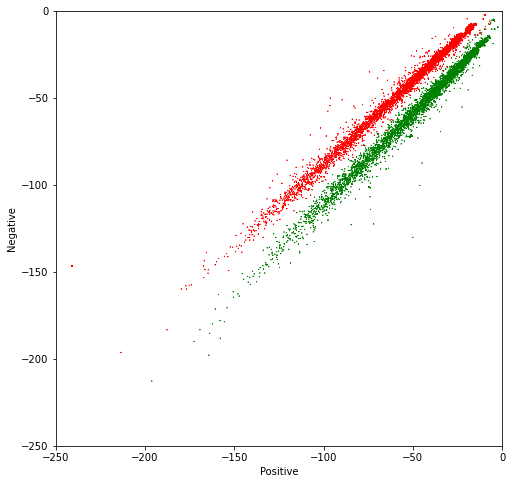

In [20]:
fig, ax = plt.subplots(figsize = (8, 8))
colors = ['red', 'green'] 

ax.scatter(df.positive, df.negative, c=[colors[int(k)] for k in df.sentiment], s = 0.1, marker='*')

plt.xlim(-250,0)
plt.ylim(-250,0)

plt.xlabel("Positive")
plt.ylabel("Negative")

### 4.3. Using Confidence Ellipses to interpret Naive Bayes

Defining confidence ellipse function

**Input**: x, y, The axes object to draw the ellipse into, The number of standard deviations to determine the ellipse's radiuses  
**Output**: confidence ellipse

In [21]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this two-dimensionl dataset
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


Ploting the data and its corresponding confidence ellipses using 2 std and 3 std

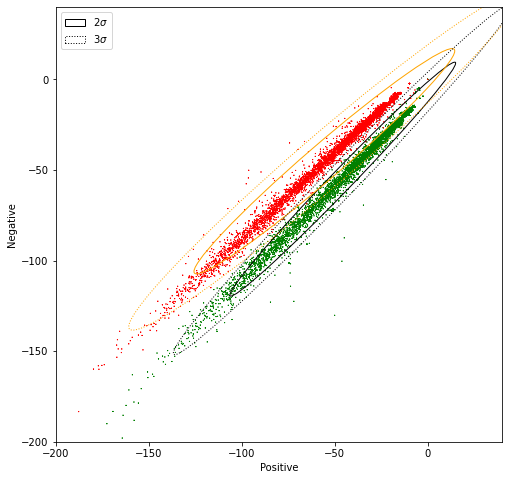

In [22]:
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

ax.scatter(df.positive, df.negative, c=[colors[int(k)] for k in df.sentiment], s = 0.1, marker='*')

plt.xlim(-200,40)  
plt.ylim(-200,40)

plt.xlabel("Positive")
plt.ylabel("Negative")

data_pos = df[df.sentiment == 1]
data_neg = df[df.sentiment == 0]

confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=2, edgecolor='black', label=r'$2\sigma$' )
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=2, edgecolor='orange')

confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=3, edgecolor='black', linestyle=':', label=r'$3\sigma$')
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=3, edgecolor='orange', linestyle=':')
ax.legend()

plt.show()